In [89]:
import pandas as pd
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

plt.style.use('ggplot')

находим изображения

In [90]:
relative_path = "/Users/daria/Downloads/hak2023-main/Data/yt/yt2/*"

imgs_path = glob(relative_path)

для тестов возьмем 5 адресов

In [91]:
imgs_path = imgs_path[:5]
imgs_path

['/Users/daria/Downloads/hak2023-main/Data/yt/yt2/5f7c6016-1895-432e-aaa3-4ae3a81a1b8a.jpg',
 '/Users/daria/Downloads/hak2023-main/Data/yt/yt2/d0568cd7-e3cc-48a1-90bd-e7eb0a7832de.png',
 '/Users/daria/Downloads/hak2023-main/Data/yt/yt2/8bd3349b-d844-4571-83ef-610d3386cb01.jpeg',
 '/Users/daria/Downloads/hak2023-main/Data/yt/yt2/a7925804-1623-496a-bd42-41933b710d45.jpg',
 '/Users/daria/Downloads/hak2023-main/Data/yt/yt2/eb2824ca-cd91-4b2a-b25a-1685ecfa6c66.jpeg']

(раскомм.) изобразить первые 20

In [92]:
# fig, axs = plt.subplots(20, 1, figsize=(50, 100))
# axs = axs.flatten()
# 
# imgs_to_print = len(imgs_path) if len(imgs_path) < 20 else 20
# 
# for i in range(imgs_to_print):
#     axs[i].imshow(plt.imread(imgs_path[i]))
#     axs[i].axis('off')
#     axs[i].set_title(imgs_path[i].split('/')[-1])
# plt.show()

указываем платформу

In [93]:
platforms_dict = {'tg': 0, 'vk': 1, 'yt1': 2, 'yt2': 3, 'zn': 4}

platform = platforms_dict['yt2']

детектим текст

In [94]:
import easyocr

reader = easyocr.Reader(['ru'], gpu = True)

Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


заведем массив содержащий имя файла и данные об обнаруженном тексте (~13сек/изображение)

In [95]:
imgs_data = pd.DataFrame(columns = ["name", "data"])

for i in range(1, len(imgs_path)):
    print(imgs_path[i])
    img_path = imgs_path[i]
    img_detect = pd.DataFrame(reader.readtext(img_path), columns=["bbox", "text", "conf"])
    img_name = img_path.split('/')[-1]

    imgs_data.loc[len(imgs_data)] = {"name": img_name, "data": img_detect}

/Users/daria/Downloads/hak2023-main/Data/yt/yt2/d0568cd7-e3cc-48a1-90bd-e7eb0a7832de.png
/Users/daria/Downloads/hak2023-main/Data/yt/yt2/8bd3349b-d844-4571-83ef-610d3386cb01.jpeg
/Users/daria/Downloads/hak2023-main/Data/yt/yt2/a7925804-1623-496a-bd42-41933b710d45.jpg
/Users/daria/Downloads/hak2023-main/Data/yt/yt2/eb2824ca-cd91-4b2a-b25a-1685ecfa6c66.jpeg


в зависимости от выбранной платформы выбираем функцию для обработки

вспомогательные функции

In [96]:
def find_strings_with_percent(strings):
    result = []

    for s in strings:
        if "%" in s:
            result.append(s)

    return result

import math
def find_rectangle_center(vertices):
    x_sum = 0
    y_sum = 0
    #print("f_r_c, vertices:", vertices)
    num_vertices = len(vertices)

    for vertex in vertices:
        x_sum += vertex[0]
        y_sum += vertex[1]

    x_center = x_sum / num_vertices
    y_center = y_sum / num_vertices

    return x_center, y_center

def is_digit(string):
    if string.isdigit():
        return True
    else:
        try:
            float(string)
            return True
        except ValueError:
            return False

def get_num_strings(df):
    num_strings = []
    for t_line in df:
        if is_digit(t_line):
            num_strings.append(t_line)
    return num_strings

tg

In [97]:
# Нахождение названия метрики на скрине
def get_metric_name_coord_tg(df):
    # Выбираем строки где есть название метрик и достаем ячейку с координатами
    t_line = df.loc[df['text'] == 'VR']['bbox']
    if t_line.empty:
        print('VR не найден')
        t_line = df.loc[df['text'] == 'ERR']['bbox']
        if t_line.empty:
            print('ERR не найден')
            t_line = df.loc[df['text'] == 'ER']['bbox']
            if t_line.empty:
                print('ER не найден')
                return
    # Получаем список координат названия
    t_coord = t_line.values[0]
    return t_coord

def get_metric_from_tg(df):
    # Нахождение название метрики на скрине
    t_coord = get_metric_name_coord_tg(df)

    # Теперь, чтобы понять какое из значений - наша метрика, будем находить центры прямоугольников с текстом
    # и наименьшее расстояние между названием метрики и строк с процентами

    center_text_x, center_text_y = find_rectangle_center(t_coord)

    distance_list = []
    text_list = []

    strings_with_percent = find_strings_with_percent(df['text'])

    for metric_text in strings_with_percent:
        metric_coord = df.loc[df['text'] == metric_text]['bbox'].values[0]
        center_x, center_y = find_rectangle_center(metric_coord)
        distance = math.sqrt((center_text_x - center_x)**2 + (center_text_y - center_y)**2)
        distance_list.append(distance)
        text_list.append(metric_text)

    # Находим индекc минимального расстояния и с помощью него ищем нашу метрику
    index = distance_list.index(min(distance_list))
    print(index)
    print('VR =', text_list[index])
    return text_list[index]

zn

In [98]:
def get_metric_name_coord_zn(df):
    # Выбираем строки где есть название метрик и достаем ячейку с координатами
    t_line = df.loc[df['text'] == 'Дочитывания']['bbox']
    if t_line.empty:
        print('Метрика не найдена')
        return
    # Получаем список координат названия
    t_coord = t_line.values[0]
    return t_coord

def get_metric_from_zn(df):
    # Нахождение название метрики на скрине
    t_coord = get_metric_name_coord_zn(df)

    # Теперь, чтобы понять какое из значений - наша метрика, будем находить центры прямоугольников с текстом
    # и наименьшее расстояние между названием метрики и строк с процентами

    centr_text_x, centr_text_y = find_rectangle_center(t_coord)

    distance_list = []
    text_list = []
    num_strings = get_num_strings(df['text'])

    for metric_text in num_strings:
        metric_coord = df.loc[df['text'] == metric_text]['bbox'].values[0]
        print(metric_coord)
        center_x, center_y = find_rectangle_center(metric_coord)
        distance = math.sqrt((centr_text_x - center_x)**2 + (centr_text_y - center_y)**2)
        distance_list.append(distance)
        text_list.append(metric_text)
    print(distance_list)

    # Находим индекc минимального расстояния и с помощью него ищем нашу метрику
    index = distance_list.index(min(distance_list))
    print(index)
    print('VR =', text_list[index])
    return text_list[index]


yt просмотры

In [99]:
def get_metric_name_coord_yt2(df):
    # Выбираем строку где есть название метрик и достаем ячейку с координатами
    t_line = df.loc[df['text'] == 'Просмотры']['bbox']
    if t_line.empty:
        print('Метрика не найдена')
        return
    # Получаем список координат названия
    t_coord = t_line.values[0]
    return t_coord

def get_matching_str_yt2(df):
    import re
    pattern = r"[1-9]*,*[1-9][ ]*(млн|тыс.)*"
    str_l = df['text']
    matching_strings = [s for s in str_l if re.match(pattern, s)]
    return matching_strings

def get_metric_from_yt2(df):
    # Нахождение название метрики на скрине
    t_coord = get_metric_name_coord_yt2(df)

    # Теперь, чтобы понять какое из значений - наша метрика, будем находить центры прямоугольников с текстом
    # и наименьшее расстояние между названием метрики и строк с процентами

    center_text_x, center_text_y = find_rectangle_center(t_coord)
    matching_strings = get_matching_str_yt2(df)
    distance_list = []
    text_list = []

    for metric_text in matching_strings:
        metric_coord = df.loc[df['text'] == metric_text]['bbox'].values[0]
        center_x, center_y = find_rectangle_center(metric_coord)
        distance = math.sqrt((center_text_x - center_x)**2 + (center_text_y - center_y)**2)
        distance_list.append(distance)
        text_list.append(metric_text)

    # Находим индекc минимального расстояния и с помощью него ищем нашу метрику
    index = distance_list.index(min(distance_list))
    return text_list[index]

yt подпищеки

In [100]:
def get_metric_name_list_yt1(df):
    import re
    pattern = r"(.)*[Пп]одписчик[аи]?(ов)?"
    str_l = df['text']
    matching_strings = [s for s in str_l if re.match(pattern, s)]
    return matching_strings

def get_metric_from_yt1(df):
    metric_text = get_metric_name_list_yt1(df)

    metric_coord = df.loc[df['text'] == metric_text[0]]['bbox'].values[0]

    center_text_x, center_text_y = find_rectangle_center(metric_coord)

    num_strings = get_num_strings(df['text'])

    distance_list = []
    text_list = []

    for metric_text in num_strings:
        metric_coord = df.loc[df['text'] == metric_text]['bbox'].values[0]
        center_x, center_y = find_rectangle_center(metric_coord)
        distance = math.sqrt((center_text_x - center_x)**2 + (center_text_y - center_y)**2)
        distance_list.append(distance)
        text_list.append(metric_text)

    # Находим индекc минимального расстояния и с помощью него ищем нашу метрику
    index = distance_list.index(min(distance_list))
    print(text_list[index])
    return text_list[index]

vk features

In [101]:
def sum(data:dict) -> int:
    sum = 0
    for i in data.keys():
        print(i)
        sum+= data[i]
    return sum

def find(df, bbox:list) -> list:
    """
    Расширяем область поиска
    """
    bboxes = df.bbox.tolist()
    text = df.text.tolist()
    for i in range(len(bboxes)):

        if (-30 < bbox[0][0] - bboxes[i][0][0] < 40) and  (0 < bbox[0][1]-bboxes[i][0][1] < 100) and text[i].isdigit():
            print(bbox[0][0] - bboxes[i][0][0])
            return int(text[i])
    else:
        return None

def convert_to_dict(string: str) -> None:
    out = string.split()
    if len(out) == 2:
        try:
            out = {out[1]: int(out[0])}
            return out
        except:
            pass

        try:
            out = {out[0]: int(out[1])}
            return out
        except:
            return None

def get_data_vk(df):
    REGEXP = r'^[1-9]*[ ]?[Дд]ру|[чн]ик[иа(ов)]*'
    use_to = pd.DataFrame(df['text'].str.lower())
    use_to['bbox'] = df['bbox']
    use_to = use_to.loc[use_to['text'].str.contains(REGEXP)]
    tmp = use_to['text'].tolist()
    bboxes = use_to['bbox'].tolist()
    out = {}

    for i in range(len(tmp)):
        g = convert_to_dict(tmp[i])
        if g:
            out.update(g)
        else:
            check = find(df, bboxes[i])
            if check:
                out.update({tmp[i]:check})

    return out

vk user

In [102]:
# from roboflow import Roboflow
# import cv2 as cv
# 
# """
# Содержит модель и функцию поиска имени аккаунта (или id)
# read_name_id_vk возвращает либо имя, либо id аккаунта
# Используется fine-tuned модель MS COCO, обученная с помощью сервиса Roboflow (нужен импорт модуля и API_KEY для доступа к ней)
# Функция read_name_id_vk возвращает имя аккаунта либо его id (в зависимости что видно на скрине)
# """
# 
# rf = Roboflow(api_key="fKNgN4TLK6ZSRlRHPdZZ")
# project = rf.workspace().project("hak2023_2")
# model = project.version(1).model
# 
# IMG_PATH = ''
# nums = 2
# 
# 
# def read_name_id_vk(data:dict, img_path) -> str:
#     """
#      Функция read_name_id_vk возвращает имя аккаунта либо его id (в зависимости что видно на скрине)
#   
#     """
# 
#     if not data['predictions']:
#         return
# 
#     if data['predictions'][0]['confidence'] < 0.5:
#         print("uncertainty")
#         return
# 
#     bbox = data['predictions'][0]
#     img = cv.imread(img_path)
# 
#     x = bbox['x'] - bbox['width']//2
#     to_x = bbox['x'] + bbox['width']//2
#     y = bbox['y'] - bbox['height']//2
#     to_y = bbox['y'] + bbox['height']//2
# 
#     cropped_img = img[y: to_y, x:to_x]
# 
#     results = reader.readtext(cropped_img)
#     out = results[0][1]
#     return out
# 
# 
# if __name__ == "__main__":
#     a = model.predict(IMG_PATH, confidence=40, overlap=30).json()
#     read_name_id_vk(a, IMG_PATH)

в зависимости от выбранной платформы будем использовать подходящую функцию

In [103]:
result = pd.DataFrame(columns=["name", "target"])

if platform == platforms_dict['tg']:
    func_processing = get_metric_from_tg
elif platform == platforms_dict['vk']:
    func_processing = get_data_vk
elif platform == platforms_dict['yt1']:
    func_processing = get_metric_from_yt1
elif platform == platforms_dict['yt2']:
    func_processing = get_metric_from_yt2
elif platform == platforms_dict['zn']:
    func_processing = get_metric_from_zn

обрабатываем все данные 

In [104]:
for i in range(len(imgs_data)):
    result.loc[len(result)] = {'name': imgs_data['name'][i], 'target': func_processing(imgs_data.loc[i]['data'])}

result

,name,target
0,d0568cd7-e3cc-48a1-90bd-e7eb0a7832de.png,255
1,8bd3349b-d844-4571-83ef-610d3386cb01.jpeg,1 041
2,a7925804-1623-496a-bd42-41933b710d45.jpg,"1,9 тыс."
3,eb2824ca-cd91-4b2a-b25a-1685ecfa6c66.jpeg,"1,5 тыс:"


(раскомм.) визуально проверить корректность обнаружения

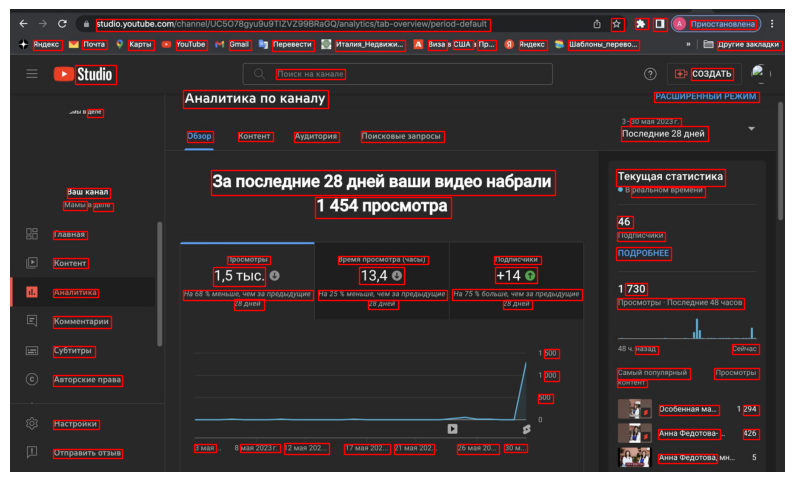

In [105]:
from matplotlib.patches import Rectangle

img_path = imgs_path[4]

detects = reader.detect(img_path)[0][0]

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(plt.imread(img_path))
ax.axis('off')

for i in range(len(detects)):
    plt.gca().add_patch(Rectangle((detects[i][0],detects[i][2]),
                                  detects[i][1] - detects[i][0],
                                  detects[i][3] - detects[i][2],
                                  edgecolor='red',
                                  facecolor='none',
                                  lw= 1 ))

plt.show()

In [106]:
writer = pd.ExcelWriter("output.xlsx")
result.to_excel(writer)
writer.save()